In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Layer, MaxPooling2D, Input, Flatten, Dense, Embedding
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, MeanSquaredError


In [3]:
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')    
anc_path = os.path.join('data', 'anchor')
# os.makedirs(pos_path)
# os.makedirs(neg_path)
# os.makedirs(anc_path)

In [4]:
# !tar -xf lfw-funneled.tgz

In [5]:
# for directory in os.listdir('lfw_funneled'):
#     for file in os.listdir(os.path.join('lfw_funneled', directory)):
#         ex_path = os.path.join('lfw_funneled', directory, file)
#         new_path = os.path.join(neg_path, file)
#         os.replace(ex_path, new_path)

In [4]:
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:370,200:450,:]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame) 
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    cv2.imshow('Image Collection', frame)
    
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
anchor = tf.data.Dataset.list_files(anc_path+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'\*.jpg').take(300)
negative= tf.data.Dataset.list_files(neg_path+'\*.jpg').take(300)

In [6]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [10]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
#validation partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [12]:
print((test_data))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [14]:
#model building 
def make_embedding():
    inp = Input(shape = (100,100,3), name = "Input image")
    #block 1 according to the paper
    c1 = Conv2D(64,(10,10), activation = 'sigmoid')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    #block 2 according to the paper
    c2 = Conv2D(128, (7,7), activation = 'sigmoid')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    #block 3 according to the paper
    c3 = Conv2D(128, (4,4), activation = 'sigmoid')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    #final embeddings
    c4 = Conv2D(256, (4,4), activation = 'sigmoid')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs= [d1], name='embedding' )


In [15]:
embedding = make_embedding()

In [16]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [13]:
#Siamese  Distance class
class L1Dist(Layer):
    def __inti__(self, **kwargs):
        super().__init__()
   #similarity calculation of the input image and the positive or the negative image 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [14]:
l1 = L1Dist()

In [18]:
def make_siamese_model():
    input_image = Input(name = 'input_img', shape = (100,100,3))
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs= [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')
    
    

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
opt = tf.keras.optimizers.Adam(1e-4)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [25]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        y_true = siamese_model(X, training = True)
        loss = binary_cross_loss(y,y_true)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [30]:
loss_metric = MeanSquaredError()
accuracy_metric = Accuracy()


In [31]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for idx , batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch %10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


In [32]:
EPOCHS = 50

In [33]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
7/7 [==============================] - 211s 30s/step

 Epoch 2/50
7/7 [==============================] - 211s 30s/step

 Epoch 3/50
7/7 [==============================] - 214s 30s/step

 Epoch 4/50
7/7 [==============================] - 216s 30s/step

 Epoch 5/50
7/7 [==============================] - 203s 28s/step

 Epoch 6/50
7/7 [==============================] - 210s 30s/step

 Epoch 7/50
7/7 [==============================] - 207s 29s/step

 Epoch 8/50
7/7 [==============================] - 199s 28s/step

 Epoch 9/50
7/7 [==============================] - 199s 28s/step

 Epoch 10/50
7/7 [==============================] - 205s 29s/step

 Epoch 11/50
7/7 [==============================] - 214s 30s/step

 Epoch 12/50
7/7 [==============================] - 215s 31s/step

 Epoch 13/50
7/7 [==============================] 

In [15]:
from tensorflow.keras.metrics import Precision, Recall

In [17]:
import cv2
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model

# Siamese Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation of the input image and the positive or the negative image
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

siamese_model = load_model('FacialRecognitionModel.h5', custom_objects={'L1Dist': L1Dist})
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [24]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [25]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]

In [26]:
y_true

array([1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

In [27]:
#creating a metric object 
m = Recall()
#calculating recall value
m.update_state(y_true,y_hat)
#return result
m.result().numpy()
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 1s/step
1.0 1.0


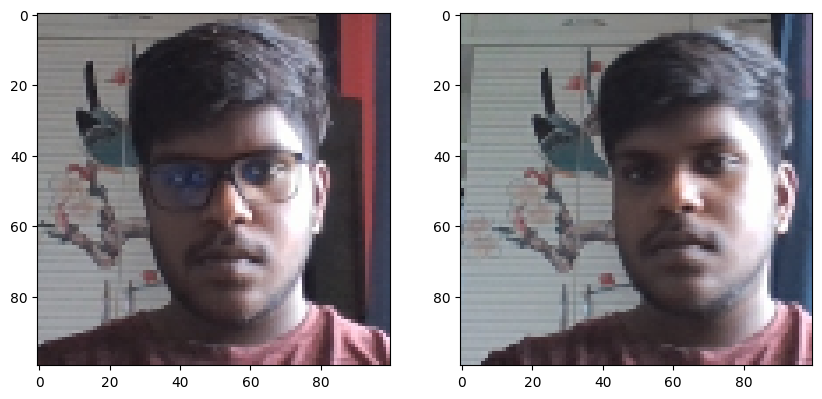

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])

plt.subplot(1,2,2)
plt.imshow(test_val[7])

In [29]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[2.3875648e-06],
       [7.8346326e-05],
       [9.9888587e-01],
       [8.0057424e-01],
       [9.9999386e-01],
       [1.8923204e-06],
       [9.9930710e-01],
       [8.9029932e-01],
       [7.8512628e-08],
       [4.6880255e-06],
       [9.9994832e-01],
       [9.9999905e-01]], dtype=float32)

In [30]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return verified

In [31]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        verified = verify( siamese_model, 1, 1)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 344ms/step
False
